In [1]:
import pandas as pd 
import numpy as np
from tqdm import tqdm
from scipy.stats import zscore, spearmanr, rankdata
from statsmodels.formula.api import ols

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [9, 5]

import os
import sys
sys.path.append('../')
from alpha_191 import Alpha191

import warnings
warnings.filterwarnings('ignore')

import feather

### 读取自存数据

In [2]:
universe = feather.read_dataframe('bitcoin_data/raw36_20220301_now.feather')
universe = universe.drop(columns=['close time'])
#universe['date'] = pd.to_datetime(universe['date'],format='%Y-%m-%d %H:%M:%S')
universe = universe.set_index(['date']).sort_values(by=['date', 'ts_code'])

In [3]:
def sum_val(series):
    return series.sum()
universe = universe.groupby('ts_code').resample('4H').agg({
                'open':'first', 'close':'last', 'high':'max', 'low':'min', 'volume':sum_val, 'amount':sum_val,
                'trade_counts':sum_val, 'buy_volume':sum_val, 'buy_amount':sum_val})
universe = universe.reset_index().set_index(['date']).sort_values(by=['date', 'ts_code'])
universe['trade_date'] = universe.index

In [5]:
#universe.loc[universe.ts_code=='BTCUSDT'].head(10)

In [6]:
universe['vwap'] = universe['amount']/universe['volume']
universe = universe.rename(columns={'open':'open_usdt', 'high':'high_usdt', 'low':'low_usdt', 
                                    'close':'close_usdt', 'vwap':'vwap_usdt'})

In [7]:
def my_groupby(df, column, func, sort_keys=['date', 'ts_code']):
    all_df = pd.DataFrame()
    for val in tqdm(df[column].unique()):
        tmp = df.loc[df[column] == val]
        all_df = all_df.append(func(tmp))
    return all_df.sort_index(level=sort_keys)

In [8]:
def convert_price_to_returns(df):
    def cal_(data):
        data['close'] = data['close_usdt'].pct_change()
        data['close'] = (data['close'].fillna(0) + 1).cumprod()
        data['vwap'] = data['vwap_usdt'].pct_change()
        data['vwap'] = (data['vwap'].fillna(0) + 1).cumprod()
        
        for feature in ['open', 'high', 'low',]:
            data[feature] = data[feature + '_usdt']/data['close_usdt'] * data['close']
        return data
    
    df = my_groupby(df, 'ts_code', cal_)
    return df

universe = convert_price_to_returns(universe)

100%|███████████████████████████████████████████| 36/36 [00:00<00:00, 45.55it/s]


In [9]:
universe['trade_date'] = universe.index
universe = universe.loc[universe.ts_code!='TUSDUSDT'].sort_values(by=['date', 'ts_code'])

<AxesSubplot:xlabel='date'>

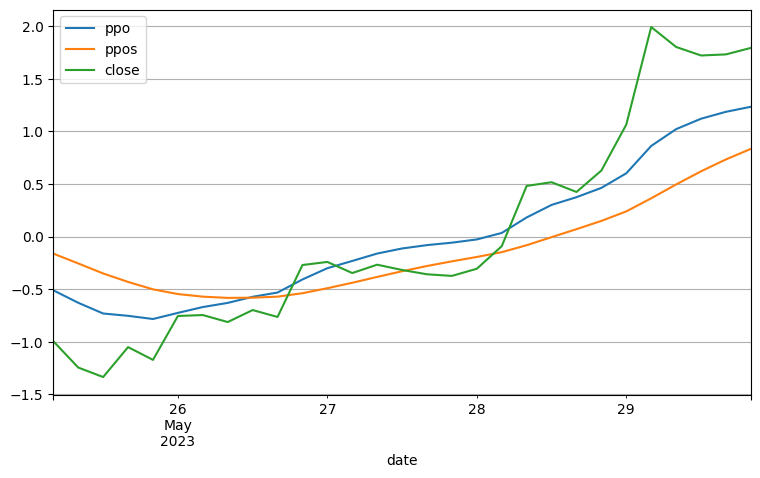

In [23]:
tmp = universe.loc[(universe.ts_code=='BTCUSDT') & (universe.index>'2023-05-25 00:00:00')]
tmp[['close']] = tmp[['close']].apply(zscore)
#universe
tmp[['ppo', 'ppos', 'close']].plot(grid=True)

### 构造技术指标为alpha

In [11]:
import stockstats

class IndicatorHelper(pd.DataFrame):
    """
        add indicators to dataframe
    """

    def __init__(self, data):
        super(IndicatorHelper, self).__init__(data)

        self.stocks = stockstats.StockDataFrame.retype(data.copy())
        self.df = self

    def add_technical_indicator(self, tech_indicator_list):
        """
        calculate technical indicators
        use stockstats package to add technical inidactors
        :param ticker: (df) pandas dataframe
        :param tech_indeicator_list list
        :return: (df) pandas dataframe
        """
        unique_ticker = self.df.ts_code.unique()

        indicator_df = pd.DataFrame()
        for i in tqdm(range(len(unique_ticker)), desc='add tech indicators'):
            temp_indicator = self.stocks[self.stocks.ts_code == unique_ticker[i]]
            temp_indicator = temp_indicator[tech_indicator_list + ['ts_code', 'trade_date']]
            indicator_df = indicator_df.append(temp_indicator, ignore_index=True)
        
        self.df = self.df.merge(indicator_df, on=["ts_code", "trade_date"], how="left")
        self.df['date'] = self.df['trade_date'].apply(lambda x: pd.Timestamp(x))
        self.df = self.df.set_index(['date']).sort_values(by=['date', 'ts_code'])
        return self.df
    

In [13]:
# add tech indicators
tech_indicator_list = ['log-ret','wt1', 'wt2','stochrsi_5', 'cci_5', 'rsi_5', 'atr_5', 'wr_5', 'ppo', 'ppos'] 
universe = IndicatorHelper(universe).add_technical_indicator(tech_indicator_list)
#universe = IndicatorHelper(universe).add_technical_indicator(['wt1', 'wt2','stochrsi_6', 'cci_6', 'rsi_6', 
#                                                              'atr_5', 'wr_5'])

add tech indicators: 100%|██████████████████████| 35/35 [00:45<00:00,  1.30s/it]


### 构造指数

In [11]:
index_df = pd.DataFrame(index=universe.index.unique())
index_df['close'] = 0.65 * universe.loc[universe.ts_code == 'BTCUSDT']['close'] \
                    + 0.35 * universe.loc[universe.ts_code == 'ETHUSDT']['close']
index_df['open'] = 0.65 * universe.loc[universe.ts_code == 'BTCUSDT']['open'] \
                + 0.35 * universe.loc[universe.ts_code == 'ETHUSDT']['open']
index_df['high'] = 0.65 * universe.loc[universe.ts_code == 'BTCUSDT']['high'] \
                + 0.35 * universe.loc[universe.ts_code == 'ETHUSDT']['high']
index_df['low'] = 0.65 * universe.loc[universe.ts_code == 'BTCUSDT']['low'] \
                + 0.35 * universe.loc[universe.ts_code == 'ETHUSDT']['low']
index_df['log-ret'] = 0.65 * universe.loc[universe.ts_code == 'BTCUSDT']['log-ret'] \
                + 0.35 * universe.loc[universe.ts_code == 'ETHUSDT']['log-ret']
index_df.head()

,close,open,high,low,log-ret
date,,,,,
2022-03-01 00:00:00,1.000000,0.992962,1.004914,0.987594,0.000000
2022-03-01 04:00:00,1.042836,0.999999,1.063419,0.997209,0.041942
2022-03-01 08:00:00,1.041506,1.042821,1.058764,1.034122,-0.001280
2022-03-01 12:00:00,1.048207,1.041506,1.050815,1.036138,0.006404
2022-03-01 16:00:00,1.047685,1.048196,1.055730,1.028998,-0.000531


In [10]:
universe['alpha_wt'] = -(universe['wt1'] - universe['wt2'])
universe['alpha_wt'] = -universe['wt1']
universe['alpha_atr'] = -universe['atr_5']
universe['alpha_cci'] = -universe['cci_5']
universe['alpha_srsi'] = -universe['stochrsi_5']
universe['alpha_rsi'] = -universe['rsi_5']
universe['alpha_wr'] = -universe['wr_5']
universe['alpha_ppo'] = (universe['ppos'] - universe['ppo'])
universe['alpha_ppos'] = -universe['ppo']

In [2]:
def Corr(data, win_len):
    obj = data.rolling(window=win_len, method='table')
    s = []
    for o in obj:
        if o.shape[0] < win_len:
            s.append(0.)
        else:
            s.append(spearmanr(o.iloc[:, 0], o.iloc[:, 1])[0])
            # s.append(o.iloc[:, 0].corr(o.iloc[:, 1]))
    return pd.DataFrame(s, index=data.index, columns=['corr'])

def ts_rank(data, window=10):
    return data.rolling(window).apply(lambda x: rankdata(x)[-1])

def sma(df, window=10):
    return df.rolling(window).mean()

def ESma(sr, n, m):
    return sr.ewm(alpha=m / n, adjust=False).mean()

def Regbeta(sr, x):
    window = len(x)
    return sr.rolling(window).apply(lambda y: np.polyfit(x, y, deg=1)[0])

def Sequence(n):
    return np.arange(1, n + 1)

def Decaylinear(sr, window):
    weights = np.array(range(1, window + 1))
    sum_weights = np.sum(weights)
    return sr.rolling(window).apply(lambda x: np.sum(weights * x) / sum_weights)

def my_groupby(df, column, func, sort_keys=['date', 'ts_code']):
    all_df = pd.DataFrame()
    for val in tqdm(df[column].unique()):
        tmp = df.loc[df[column] == val]
        all_df = all_df.append(func(tmp))
    return all_df.sort_values(by=sort_keys)

### 构造一些基础指标
给机器学习提供参考

In [26]:
def base_indicators(df):
    def cal_(data):
        data['range_6'] = data['high'].rolling(10).max() - data['low'].rolling(12).min()
        data['wave_6'] = data['close'].rolling(10).std()
        data['range_12'] = data['high'].rolling(5).max() - data['low'].rolling(5).min()
        data['wave_12'] = data['close'].rolling(5).std()
        data['ret_6'] = data['log-ret'].rolling(5).sum()
        data['ret_12'] = data['log-ret'].rolling(10).sum()
        return data
    
    df = my_groupby(df, 'ts_code', cal_)
    return df

universe = base_indicators(universe)

100%|███████████████████████████████████████████| 35/35 [00:01<00:00, 30.87it/s]


### 构造alpha因子

In [27]:
def alpha_t1(df):
    def cal_(data):
        data['alpha_t1'] = -(data['close'] - data['close'].rolling(5).mean())\
                            /data['close'].rolling(5).std()
        return data
    
    df = my_groupby(df, 'ts_code', cal_)
    return df

universe = alpha_t1(universe) 

100%|███████████████████████████████████████████| 35/35 [00:00<00:00, 37.86it/s]


In [28]:
def alpha_t2(df):
    def cal_(data):
        data['alpha_t2'] = data['buy_amount']/(data['amount'] - data['buy_amount'])
        return data
    
    df = my_groupby(df, 'ts_code', cal_)
    return df
universe = alpha_t2(universe) 

100%|███████████████████████████████████████████| 35/35 [00:00<00:00, 36.01it/s]


In [63]:
def alpha_t3(df):
    def cal_(df): # 040
        cond = df['close'] > df['close'].shift(1)
        df['section1'] = np.where(cond, df['close'].diff(1), 0)
        df['section2'] = np.where(~cond, df['close'].diff(1), 0)
        df['section1'] = df['section1'].rolling(6).sum()
        df['section2'] = df['section2'].rolling(6).sum()
        return df

    df = my_groupby(df, 'ts_code', cal_)
    df['alpha_t3'] = df['section1'] / df['section2']
    df = df.drop(columns=['section1', 'section2'])
    return df

universe = alpha_t3(universe)

100%|███████████████████████████████████████████| 35/35 [00:01<00:00, 23.70it/s]


In [30]:
def alpha_t4(df):
    def cal_(data):
        wave = data['high'].rolling(4).max() - data['low'].rolling(4).min()
        data['alpha_t4'] = -(data['close']-data['low'])/wave
        return data
    
    df = my_groupby(df, 'ts_code', cal_)
    return df

universe = alpha_t4(universe)

100%|███████████████████████████████████████████| 35/35 [00:00<00:00, 35.50it/s]


In [31]:
def alpha_t5(df):
    def cal_(data):
        data['alpha_t5'] = -(2 * data['close'] - data['high'] - data['low']) * data['alpha_t2']
        return data
    
    df = my_groupby(df, 'ts_code', cal_)
    return df

universe = alpha_t5(universe)

100%|███████████████████████████████████████████| 35/35 [00:00<00:00, 36.46it/s]


In [24]:
def alpha_t9(df):
    def cal_(df):
        benchmark_close = index_df.loc[df.index]['close']
        df['alpha_t9'] = df['close'].rolling(6).apply(
                            lambda y: np.polyfit(benchmark_close.loc[y.index], y, deg=1)[0])
        #df['alpha_t9'] = df['alpha_t9'].diff(1)
        return df
    
    df = my_groupby(df, 'ts_code', cal_)
    return df

universe = alpha_t9(universe)

100%|███████████████████████████████████████████| 35/35 [01:22<00:00,  2.36s/it]


In [62]:
def alpha019(df):
    def cal_(df):
        df['alpha_019'] = -np.where(df['close'] < df['close'].shift(1),
                                   (df['close'] - df['close'].shift(1)) / df['close'].shift(1),
                                   np.where(df['close'] > df['close'].shift(1),
                                            (df['close'] - df['close'].shift(1)) / df['close'], 0.))
        return df

    df = my_groupby(df, 'ts_code', cal_)
    return df

universe = alpha019(universe)

100%|███████████████████████████████████████████| 35/35 [00:01<00:00, 26.12it/s]


In [12]:
alpha = Alpha191(universe, index_df, True)

In [40]:
universe = alpha.alpha018(alpha.df)

In [42]:
universe = alpha.alpha022(alpha.df)

In [45]:
universe = alpha.alpha028(alpha.df)

In [46]:
universe = alpha.alpha029(alpha.df)

In [47]:
universe = alpha.alpha040(alpha.df)

In [51]:
universe = alpha.alpha078(alpha.df)

In [52]:
universe = alpha.alpha083(alpha.df)

In [54]:
universe = alpha.alpha110(alpha.df)

In [55]:
universe = alpha.alpha122(alpha.df)

In [56]:
universe = alpha.alpha128(alpha.df)

In [57]:
universe = alpha.alpha133(alpha.df)

In [13]:
universe = alpha.alpha112(alpha.df)

In [59]:
universe = alpha.alpha131(alpha.df)

processing1...: 100%|███████████████████████████| 35/35 [01:33<00:00,  2.67s/it]


In [60]:
universe = alpha.alpha190(alpha.df)

In [61]:
def alpha075(df):
    def cal_(df):
        benchmark_close = index_df.loc[df.index]['close']
        benchmark_return = index_df.loc[df.index]['log-ret']
        cond1 = ((df['log-ret']<-0.002) & (benchmark_return > 0))
        cond2 = ((df['log-ret']<-0.002) & (benchmark_close > benchmark_close.shift(1)))
        cond3 = ((df['log-ret']>0.002) & (benchmark_return < 0))
        cond4 = ((df['log-ret']>0.002) & (benchmark_close < benchmark_close.shift(1)))
        df['section1'] = np.where(cond1, -df['log-ret'], np.where(cond3, -df['log-ret'], 0))
        df['section2'] = np.where(cond2, -df['log-ret'], np.where(cond4, -df['log-ret'], 0))
        df['alpha_075'] = df['section1'].rolling(6).sum() + df['section2'].rolling(6).sum()
        return df

    df = my_groupby(df, 'ts_code', cal_)
    df = df.drop(columns=['section1', 'section2'])
    return df

universe = alpha075(universe)

100%|███████████████████████████████████████████| 35/35 [00:01<00:00, 25.82it/s]


In [62]:
alpha.df = universe.copy(deep=True)
bak = universe.copy(deep=True)

In [15]:
universe.columns

Index(['ts_code', 'open_usdt', 'close_usdt', 'high_usdt', 'low_usdt', 'volume',
       'amount', 'trade_counts', 'buy_volume', 'buy_amount', 'trade_date',
       'vwap_usdt', 'close', 'vwap', 'open', 'high', 'low', 'log-ret', 'wt1',
       'wt2', 'stochrsi_5', 'cci_5', 'rsi_5', 'atr_5', 'wr_5', 'ppo', 'ppos',
       'alpha_wt', 'alpha_atr', 'alpha_cci', 'alpha_srsi', 'alpha_rsi',
       'alpha_wr', 'alpha_ppo', 'alpha_ppos', 'range_6', 'wave_6', 'range_12',
       'wave_12', 'ret_6', 'ret_12', 'alpha_t1', 'alpha_t2', 'alpha_t3',
       'alpha_t4', 'alpha_t5', 'alpha_t6', 'alpha_t7', 'alpha_t9', 'alpha_019',
       'alpha_010', 'alpha_018', 'alpha_021', 'alpha_022', 'alpha_023',
       'alpha_026', 'alpha_029', 'alpha_028', 'alpha_040', 'alpha_044',
       'alpha_061', 'alpha_077', 'alpha_078', 'alpha_083', 'alpha_089',
       'alpha_110', 'alpha_122', 'alpha_128', 'alpha_133', 'alpha_112',
       'alpha_131', 'alpha_190', 'alpha_075'],
      dtype='object')

In [64]:
universe.reset_index().to_feather('bitcoin_data/factor_data/factors4h_20220301_20230529.feather')
#universe[final_columns].reset_index().to_feather('bitcoin_data/factor_data/factors_20221001_20230529.feather')

In [61]:
universe = pd.read_feather('bitcoin_data/factor_data/factors4h_20220301_20230529.feather')
universe = universe.set_index(['date']).sort_values(by=['date', 'ts_code'])
universe.shape

(90570, 73)

### 因子评估

In [65]:
negative_field = [ 'alpha_022', 'alpha_028', 'alpha_078', 'alpha_131',
                  'alpha_110', 'alpha_112', 'alpha_128', 'alpha_122',]
universe[negative_field] = -universe[negative_field]

In [18]:
base_columns = [
    'ts_code', 'trade_date', 'volume', 'amount', 'trade_counts', 'buy_volume', 'buy_amount',
    'close', 'vwap', 'open', 'high', 'low',  'log-ret', 'range_6', 'wave_6', 'range_12', 'wave_12', 'ret_6', 'ret_12']

In [28]:
# t7 not need zscore
factor_names = [
       'alpha_t4', 'alpha_srsi', 'alpha_018',  'alpha_wr', 'alpha_t1',  'alpha_t5', 
       'alpha_t9', 'alpha_rsi', 'alpha_cci', 'alpha_t3', 
       'alpha_019', 'alpha_029', 'alpha_028', 'alpha_075', 'alpha_040', 'alpha_110'
        ]

final_columns = base_columns+factor_names

In [29]:
def rescale_(data, zscore_features=factor_names):
    data[factor_names] = data[factor_names].apply(zscore)
    # resize from -1 to 1
    for feature in zscore_features:
        max_val = data[feature].median() + 3*data[feature].std()
        min_val = data[feature].median() - 3*data[feature].std()
        data[feature] = np.where(data[feature]>max_val, max_val, 
                               np.where(data[feature]<min_val, min_val, data[feature]))
        #data[feature] = (data[feature] - data[feature].mean())/data[feature].std()
        #data[feature] = np.where(data[feature]>0, data[feature]/data[feature].max(),
                                 #np.where(data[feature]<0, data[feature]/(-data[feature].min()), 0.))
    data[zscore_features] = data[zscore_features]/3
    return data

def rescale_rank(data, zscore_features=factor_names):
    data[zscore_features] = data[zscore_features].rank(method='min',pct=True)
    data[zscore_features] = (data[zscore_features] - 0.5) * 2
    return data

universe = universe.replace([np.inf, -np.inf], np.nan)
universe = universe.fillna(0.)

#universe[factor_names] = universe.groupby('ts_code')[factor_names].apply(lambda x: Decaylinear(x, 4))
universe = my_groupby(universe, 'trade_date', rescale_)
#universe = my_groupby(universe, 'trade_date', rescale_rank)

100%|███████████████████████████████████████| 2730/2730 [04:04<00:00, 11.14it/s]


In [30]:
universe[final_columns].reset_index().to_feather(
    'bitcoin_data/factor_data/factors4h_zscore.feather')

In [ ]:
universe = pd.read_feather('bitcoin_data/factor_data/factors2h_zscore.feather')
universe = universe.set_index(['date']).sort_values(by=['date', 'ts_code'])
universe.shape

In [31]:
start_time = '2023-03-01 00:00:00'
end_time = '2023-06-01 00:00:00'
# universe = universe.loc[(universe.index>=start_time) & (universe.index<=end_time)]

<AxesSubplot:>

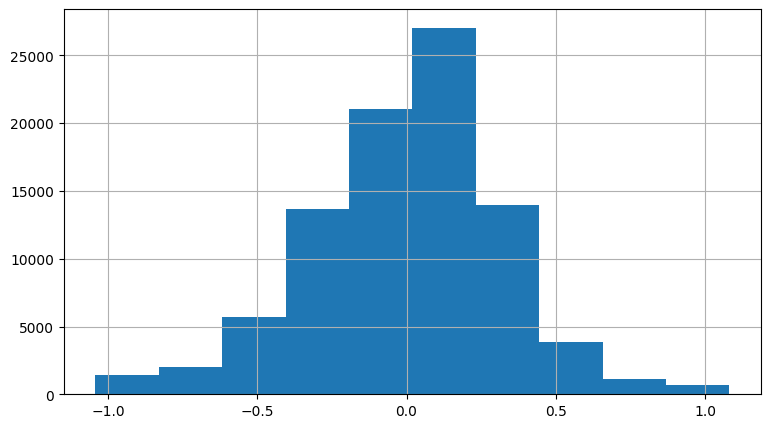

In [32]:
universe['alpha_t1'].hist()

### 构造评估数据

In [33]:
import random
universe = universe.sort_values(by=['date','ts_code'])
all_factors = universe.copy(deep=True)
all_factors = all_factors.loc[(all_factors.index>=start_time) & (all_factors.index<=end_time)]
def return_handle(df):
    df['returns_2'] = df['close'].pct_change().shift(-1)
#     noise_list = []
#     for i in range(df.shape[0]):
#         noise = abs(random.gauss(0, 0.2))
#         if noise > 0.2:
#             noise=0.1
#         noise_list.append(noise)
#     df['returns_2'] = df['returns_2'] * (1 - np.array(noise_list)) \
#                     + np.array(noise_list)*df['close'].pct_change().shift(-1).fillna(0.)
    return df
all_factors = all_factors.groupby('ts_code').apply(return_handle)
all_factors = all_factors.replace([np.inf, -np.inf], np.nan).fillna(0.).sort_values(by=['date', 'ts_code'])
print(universe.shape, all_factors.shape)

(90570, 73) (18900, 74)


In [34]:
def keep_top_bottom(data, feature, bottom=0.2, top=0.8):
    tv = data[feature].quantile(top)
    bv = data[feature].quantile(bottom)
    data[feature] = np.where(data[feature]>tv, data[feature], 
                            np.where(data[feature]<bv, data[feature], 0))
    return data
    
    all_df = pd.DataFrame()
    for dt in tqdm(df.index.unique()):
        tmp = df.loc[df.index == dt]
        all_df = all_df.append(cal_(tmp))
    return all_df.sort_values(by=['date', 'ts_code'])


def wins(x,a,b):
    return np.where(x <= a,a, np.where(x >= b, b, x))

def get_formula(factors, Y):
    L = ["0"]
    L.extend(factors)
    return Y + " ~ " + " + ".join(L)

def factors_from_names(n, name):
    return list(filter(lambda x: name in x, n))

def estimate_factor_returns(df, name='alpha_'): 
    ## winsorize returns for fitting 
    estu = df.copy(deep=True)
    estu['returns_2'] = wins(estu['returns_2'], -0.1, 0.1)
    #all_factors = factors_from_names(list(df), name)
    results = pd.Series()
    for factor_name in factor_names:
        #estu = keep_top_bottom(estu, factor_name)
        form = get_formula([factor_name], "returns_2")
        model = ols(form, data=estu)
        result = model.fit()
        results = results.append(result.params)
    return results

In [35]:
base_field = ['ts_code', 'log-ret', 'open', 'high', 'low', 'close', 'volume', 'vwap','trade_date']
date_and_code = [ 'ts_code', 'returns_2']

alpha_df = all_factors[factor_names + date_and_code].copy(deep=True)
#alpha_df = alpha_df.loc[alpha_df.index<=start_time]
calendar = alpha_df.index.unique() # int64

#alpha_df = keep_top_bottom(alpha_df, factor_names)

In [36]:
calendar

DatetimeIndex(['2023-03-01 00:00:00', '2023-03-01 04:00:00',
               '2023-03-01 08:00:00', '2023-03-01 12:00:00',
               '2023-03-01 16:00:00', '2023-03-01 20:00:00',
               '2023-03-02 00:00:00', '2023-03-02 04:00:00',
               '2023-03-02 08:00:00', '2023-03-02 12:00:00',
               ...
               '2023-05-28 08:00:00', '2023-05-28 12:00:00',
               '2023-05-28 16:00:00', '2023-05-28 20:00:00',
               '2023-05-29 00:00:00', '2023-05-29 04:00:00',
               '2023-05-29 08:00:00', '2023-05-29 12:00:00',
               '2023-05-29 16:00:00', '2023-05-29 20:00:00'],
              dtype='datetime64[ns]', name='date', length=540, freq=None)

### 方法1
线性回归评估

In [37]:
### ols to estimate 
facret = {}
for dt in tqdm(calendar, desc='regression factor returns'):
    facret[dt] = estimate_factor_returns(alpha_df.loc[alpha_df.index==dt])

regression factor returns: 100%|██████████████| 540/540 [01:19<00:00,  6.76it/s]


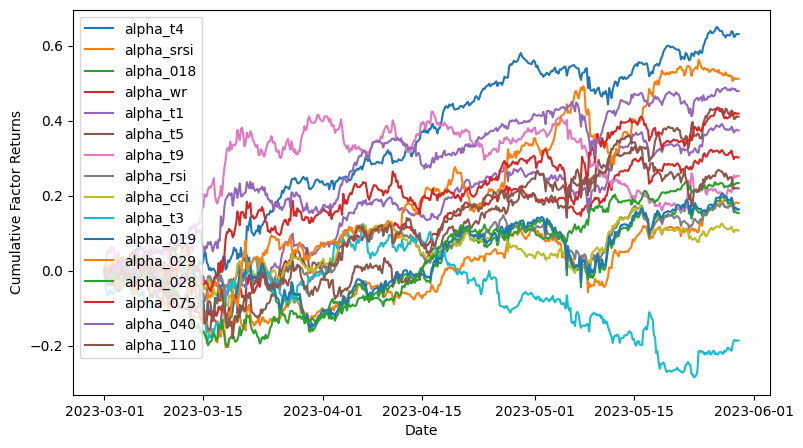

In [59]:
### plot
date_list = alpha_df.index.unique()
facret_df = pd.DataFrame(index = date_list)

for ii, dt in zip(calendar,date_list): 
    for alp in factor_names: 
        facret_df.at[dt, alp] = facret[ii][alp]

display_field  = [ 
       'alpha_t4', 'alpha_srsi', 'alpha_018',  'alpha_wr', 'alpha_t1',  'alpha_t5', 
       'alpha_t9', 'alpha_rsi', 'alpha_cci', 'alpha_t3', 
       'alpha_019', 'alpha_029', 'alpha_028', 'alpha_075', 'alpha_040', 'alpha_110'
]        

for column in display_field:
    plt.plot(facret_df[column].cumsum(), label=column)
    #plt.plot(facret_df[column], label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Cumulative Factor Returns')
plt.show()

In [60]:
# sharp ratio
np.sqrt(6*252) * (facret_df[display_field].mean())/ facret_df[display_field].std()

alpha_t4      4.522013
alpha_srsi    1.215703
alpha_018     0.835640
alpha_wr      2.390164
alpha_t1      2.714994
alpha_t5      2.315734
alpha_t9      1.550593
alpha_rsi     1.208125
alpha_cci     0.840412
alpha_t3     -1.058123
alpha_019     0.908554
alpha_029     2.616245
alpha_028     2.074954
alpha_075     2.360788
alpha_040     3.296900
alpha_110     1.233984
dtype: float64

In [ ]:
def cal_auto_corr(data, alpha_cols):
    for column in tqdm(alpha_cols):  
        data[column + '_shift1'] = data.groupby(level=0)[column].shift(-1)
        
    corr_df = pd.DataFrame(index = data.index.unique())
    for dt in tqdm(data.index.unique()):
        tmp = data.loc[dt]
        for column in alpha_cols:
            corr_df.at[dt, column] = tmp[column].corr(tmp[column + '_shift1'])
    return corr_df

corr_df = cal_auto_corr(alpha_df, display_field)

In [ ]:
print(corr_df[['alpha_t5', 'alpha_078']].mean())
corr_df[['alpha_t5', 'alpha_078']].plot(grid=True)

### 方法2
归一化回报率评估

In [ ]:
q_num = 5
df = pd.DataFrame(index=alpha_df.index.unique())
for dt in tqdm(alpha_df.index.unique()):
    tmp = alpha_df.loc[alpha_df.index == dt]
    for feature in factor_names:
        tmp = keep_top_bottom(tmp, feature)
        tmp['returns_2'] = wins(tmp['returns_2'], -0.3, 0.3)
        df.at[dt, feature] = (tmp['returns_2'] * tmp[feature]).sum()/(tmp[feature].abs().sum())
        # calculate quartile 3 returns
        try:
            tmp[feature + '_q' + str(q_num)] = pd.qcut(tmp[feature], q=q_num, 
                                                       labels=list(range(1,q_num+1)), duplicates='drop')
        except Exception as e:
            tmp[feature + '_q' + str(q_num)] = 3
        for q in range(1, q_num+1):
            # 1q 2q 3q 4q 5q
            df.at[dt, feature + '_q' + str(q)] = tmp.loc[tmp[feature + '_q'+str(q_num)]==q]['returns_2'].sum()

In [ ]:
### one hour use features
# display_field  = [ 
#        'alpha_cci', 'alpha_srsi', 'alpha_wr', 'alpha_t9','alpha_028', 'alpha_019', 
#        'alpha_rsi', 'alpha_t1', 'alpha_122', 'alpha_044', 'alpha_111', 'alpha_078',
#        'alpha_t2', 'alpha_t3', 'alpha_t4', 'alpha_t5', 'alpha_t6', 'alpha_t7', 
#        'alpha_110',  'alpha_128', 'alpha_112', 
#         ]

display_field = [
    #'alpha_cci', 'alpha_srsi', 'alpha_wr', 'alpha_t1', 'alpha_t9','alpha_028', 'alpha_019', 
    'alpha_rsi', 'alpha_t5', 'alpha_122', 'alpha_044', 'alpha_078',  'alpha_128', 
]

df[display_field].cumsum().plot()

In [ ]:
# sharp ratio
np.sqrt(22*240) * df[display_field].mean()/ df[display_field].std()

In [ ]:
# alpha_008    7.112507
# alpha_078    5.924321
# alpha_019    5.641981
# alpha_wt     6.093409
# alpha_cci    5.723536
# alpha_035    5.557689

feature = 'alpha_t1'
q_df = pd.DataFrame(index = df.index)
for i in range(1, q_num+1):
    q_feature = feature + '_q' + str(i)
    if q_feature in df.columns:
        q_df[q_feature] = (df[q_feature]).cumsum()

q_df.plot()        

### Save  or read rescale data

In [ ]:
field = ['ts_code', 'close', 'log-ret', 'trade_date',
         'alpha_019', 'alpha_wr', 'alpha_srsi', 'alpha_combine', 
        ]
universe[field].reset_index().to_feather('bitcoin_data/factor_data/facotor2h_bitcon_combine.feather')

In [ ]:
universe_raw = feather.read_dataframe('bitcoin_data/factor_data/factors_smooth_zscore_20221001_20230529.feather')
#universe_raw['date'] = pd.to_datetime(universe_raw['trade_date'], format='%Y-%m-%d %H:%M:%S')
universe_raw = universe_raw.set_index(['date']).sort_values(by=['date', 'ts_code'])
print(universe_raw.shape)

In [ ]:
universe_raw.columns

In [ ]:
feature = 'alpha_atr'
start_time = '2023-03-01 00:00:00'
end_time = '2023-06-01 00:00:00'
tmp = universe_raw.loc[(universe_raw.ts_code=='SHIBUSDT') & (universe_raw.index>=start_time) & (universe_raw.index<=end_time)]
#tmp[['close']] = tmp[['close']].apply(zscore)
#tmp[feature] = Decaylinear(tmp[feature],4)#.rolling(6).mean()
tmp[[feature, 'close']].plot(grid=True)